# Play with feature importance

Note that for the SHAP plots I use my own fork 

In [34]:
import sys 
import os 
from pathlib import Path 
import numpy as np 
import joblib

%load_ext autoreload
%autoreload 2

import pandas as pd
import shap 
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 
%matplotlib inline 

import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'

DATADIR = '../data'
TRAIN_SIZE = 0.7


import sys 
sys.path.append('../')
from dispersant_screener.definitions import FEATURES
from dispersant_screener.utils import plot_parity


import wandb
from lightgbm import LGBMRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([
    rg.reshape(-1, 1),
    -gibbs.reshape(-1, 1),
    gibbs_max.reshape(-1, 1),
    force_max.reshape(-1, 1),
    deltaGMax.reshape(-1, 1),
    a2.reshape(-1, 1)
])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

In [40]:
force_max.max()

2.0282957083665787

In [41]:
feats = list(pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv')).columns)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df_full_factorial_feat[FEATURES], y, train_size=TRAIN_SIZE)

# vt = VarianceThreshold(0)
# X_train = vt.fit_transform(X_train)
# X_test = vt.transform(X_test)

feat_scaler = StandardScaler()
X_train = feat_scaler.fit_transform(X_train)
X_test = feat_scaler.transform(X_test)

## Target 0: Radius of gyration ([sweep salenc0b](https://app.wandb.ai/kjappelbaum/dispersant_screener/sweeps/salenc0b))

In [53]:
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/z0yjpku7/overview?workspace=user-kjappelbaum
config_0 = {
    "max_depth":  39,
    "reg_alpha": 1.174,
    "subsample": 0.3647,
    "num_leaves": 489,
    "reg_lambda": 1.178,
    "n_estimators": 340,
    "colsample_bytree":  0.1862,
    "min_child_weight": 0.00554
}

In [54]:
lgbm_0 = LGBMRegressor(**config_0)

In [55]:
lgbm_0.fit(X_train, y_train[:,0])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.1862,
              importance_type='split', learning_rate=0.1, max_depth=39,
              min_child_samples=20, min_child_weight=0.00554,
              min_split_gain=0.0, n_estimators=340, n_jobs=-1, num_leaves=489,
              objective=None, random_state=None, reg_alpha=1.174,
              reg_lambda=1.178, silent=True, subsample=0.3647,
              subsample_for_bin=200000, subsample_freq=0)

In [56]:
train_0_predict = lgbm_0.predict(X_train)
test_0_predict = lgbm_0.predict(X_test)

In [57]:
plot_parity([(y_train[:,0], train_0_predict, [0]*len(y_train)), (y_test[:,0], test_0_predict, [0]*len(y_test))], '../models/GBDT/parity_target_0_radius.pdf', titles=['train', 'test'])


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


In [58]:
shap_0_radius = shap.TreeExplainer(lgbm_0)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [59]:
shap_0_radius_values = shap_0_radius.shap_values(X_train)

not enough data in bin #6 for feature max_[Ta], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #7 for feature max_[Ta], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #6 for feature max_[Tr], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #7 for feature max_[Tr], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #6 for feature max_[W], so it'll be ignored. Try increasing the number of records to plot.


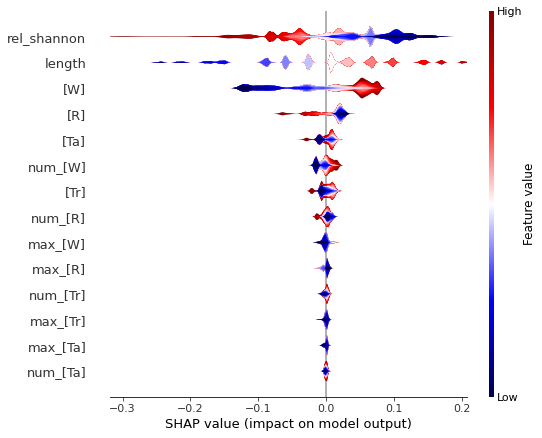

In [62]:
shap.summary_plot(shap_0_radius_values, X_train, FEATURES, plot_type='layered_violin', show=False,color='seismic' )
plt.savefig('../models/GBDT/SHAP_summary_target_radius.pdf', bbox_inches='tight', )

## Target 1: deltaGmin ([sweep wcbj76hy](https://app.wandb.ai/kjappelbaum/dispersant_screener/sweeps/wcbj76hy))

In [63]:
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/wog4qfb2/overview?workspace=user-kjappelbaum
config_1 ={
    "max_depth":  73,
    "reg_alpha": 1.392732983015451,
    "subsample":  0.5009306968568509,
    "num_leaves":  6,
    "reg_lambda": 1.0595847294980203,
    "n_estimators":  461,
    "colsample_bytree": 0.966043658485258,
    "min_child_weight": 0.0039362945584385705
}

In [64]:
lgbm_1 = LGBMRegressor(**config_1)

In [65]:
lgbm_1.fit(X_train, y_train[:,1])

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.966043658485258, importance_type='split',
              learning_rate=0.1, max_depth=73, min_child_samples=20,
              min_child_weight=0.0039362945584385705, min_split_gain=0.0,
              n_estimators=461, n_jobs=-1, num_leaves=6, objective=None,
              random_state=None, reg_alpha=1.392732983015451,
              reg_lambda=1.0595847294980203, silent=True,
              subsample=0.5009306968568509, subsample_for_bin=200000,
              subsample_freq=0)

In [66]:
train_1_predict = lgbm_1.predict(X_train)
test_1_predict = lgbm_1.predict(X_test)

In [67]:
plot_parity([(y_train[:,1], train_1_predict, [0]*len(y_train)), (y_test[:,1], test_1_predict, [0]*len(y_test))], '../models/GBDT/parity_target_1_deltaGMin.pdf', titles=['train', 'test'])


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


In [68]:
joblib.dump(lgbm_1, '../models/gbdt/target_1.joblib')

['../models/gbdt/target_1.joblib']

In [69]:
explainer_1 = shap.TreeExplainer(lgbm_1)

shap_values_1 = explainer_1.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


not enough data in bin #6 for feature max_[Tr], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #7 for feature max_[Tr], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #6 for feature max_[Ta], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #7 for feature max_[Ta], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #6 for feature max_[W], so it'll be ignored. Try increasing the number of records to plot.


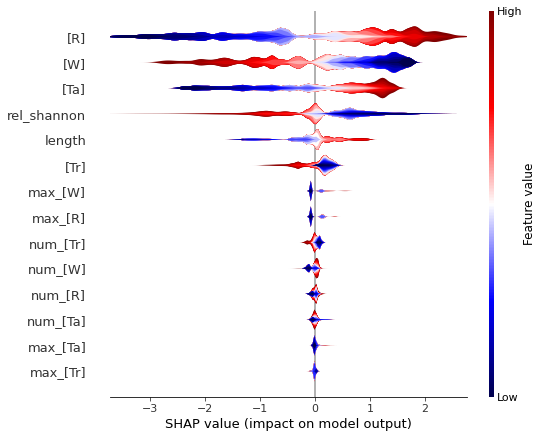

In [70]:
shap.summary_plot(shap_values_1, X_train, feature_names = FEATURES, plot_type='layered_violin', show=False, color='seismic')
plt.savefig('../models/GBDT/SHAP_summary_target_1_deltaGMin.pdf', bbox_inches='tight')

## Target 2: Gibbs Max ([sweep s74oibke](https://app.wandb.ai/kjappelbaum/dispersant_screener/sweeps/s74oibke))

In [80]:
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/ljzi9uad/overview?workspace=user-kjappelbaum
config_2= {
    "max_depth":  22,
    "reg_alpha": 1.4445428983500173,
    "subsample":  0.37540621157955995,
    "num_leaves": 11,
    "reg_lambda": 1.246760700982355,
    "n_estimators":  56,
    "colsample_bytree": 0.9850898928749316,
    "min_child_weight": 0.05716405492260722
}

In [81]:
lgbm_2 = LGBMRegressor(**config_2)

In [82]:
lgbm_2.fit(X_train, y_train[:,2])

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.9850898928749316, importance_type='split',
              learning_rate=0.1, max_depth=22, min_child_samples=20,
              min_child_weight=0.05716405492260722, min_split_gain=0.0,
              n_estimators=56, n_jobs=-1, num_leaves=11, objective=None,
              random_state=None, reg_alpha=1.4445428983500173,
              reg_lambda=1.246760700982355, silent=True,
              subsample=0.37540621157955995, subsample_for_bin=200000,
              subsample_freq=0)

In [83]:
train_2_predict = lgbm_2.predict(X_train)
test_2_predict = lgbm_2.predict(X_test)

In [84]:
plot_parity([(y_train[:,2], train_2_predict, [0]*len(y_train)), (y_test[:,2], test_2_predict, [0]*len(y_test))],  '../models/GBDT/parity_target_2_GMax.pdf', titles=['train', 'test'])


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


In [85]:
joblib.dump(lgbm_2, '../models/gbdt/target_2.joblib')

['../models/gbdt/target_2.joblib']

In [86]:
explainer_2 = shap.TreeExplainer(lgbm_2)

shap_values_2 = explainer_2.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


not enough data in bin #6 for feature num_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #7 for feature num_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #6 for feature head_tail_[R], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #7 for feature head_tail_[R], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #6 for feature head_tail_[Tr], so it'll be ignored. Try increasing the number of records to plot.


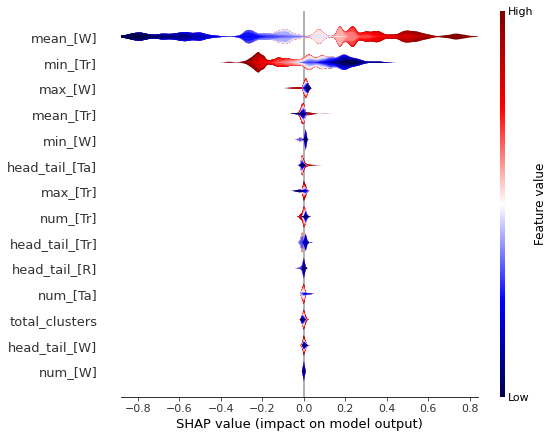

In [87]:
shap.summary_plot(shap_values_2, X_train, feature_names = feats, plot_type='layered_violin', show=False, color='seismic')
plt.savefig('../models/GBDT/SHAP_summary_target_2_GMax.pdf', bbox_inches='tight')

## Target 3: Force ([sweep 8i3jbvuh](//app.wandb.ai/kjappelbaum/dispersant_screener/sweeps/8i3jbvuh))

The force is nothing we're that much predictive for ... 

In [41]:
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/bqtb27vj/overview?workspace=user-kjappelbaum

config_3 = {
    "max_depth":  46,
    "reg_alpha":  1.4190514195959132,
    "subsample":  0.5165257833023812,
    "num_leaves":  5,
    "reg_lambda":  1.4086803323009371,
    "n_estimators": 184,
    "colsample_bytree":  0.2665904888126897,
    "min_child_weight": 0.07178485922622846
}

In [42]:
lgbm_3 = LGBMRegressor(**config_3)

In [43]:
lgbm_3.fit(X_train, y_train[:,3])

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.2665904888126897, importance_type='split',
              learning_rate=0.1, max_depth=46, min_child_samples=20,
              min_child_weight=0.07178485922622846, min_split_gain=0.0,
              n_estimators=184, n_jobs=-1, num_leaves=5, objective=None,
              random_state=None, reg_alpha=1.4190514195959132,
              reg_lambda=1.4086803323009371, silent=True,
              subsample=0.5165257833023812, subsample_for_bin=200000,
              subsample_freq=0)

In [44]:
train_3_predict = lgbm_3.predict(X_train)
test_3_predict = lgbm_3.predict(X_test)

In [46]:
plot_parity([(y_train[:,3], train_3_predict, [0]*len(y_train)), (y_test[:,3], test_3_predict, [0]*len(y_test))],  '../models/GBDT/parity_target_3_force.pdf', titles=['train', 'test'])

In [47]:
joblib.dump(lgbm_3, '../models/gbdt/target_3.joblib')

['../models/gbdt/target_3.joblib']

In [48]:
explainer_3 = shap.TreeExplainer(lgbm_3)

shap_values_3 = explainer_3.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


not enough data in bin #15 for feature mean_[Tr], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #16 for feature mean_[Tr], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #11 for feature mean_[R], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #2 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #5 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #10 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #13 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.


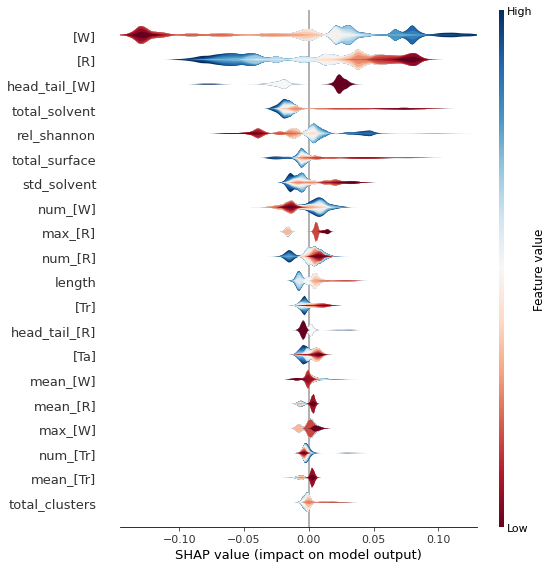

In [49]:
shap.summary_plot(shap_values_3, X_train, feature_names = feats, plot_type='layered_violin', show=False)
plt.savefig('../models/GBDT/SHAP_summary_target_3_force.pdf', bbox_inches='tight')

## Target 4: Delta GMax ([sweep dh0geaxg](https://app.wandb.ai/kjappelbaum/dispersant_screener/sweeps/dh0geaxg))

Here, we are not predictive at all? 

In [50]:
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/px0xfs9j?workspace=user-kjappelbaum
config_4 = {
    "max_depth":  68,
    "reg_alpha":  1.0044777968027732,
    "subsample":  0.1093663980746191,
    "num_leaves": 432,
    "reg_lambda": 1.4439222674444157,
    "n_estimators": 2181,
    "colsample_bytree": 0.8319215723920813,
    "min_child_weight":  0.04250151599861387
}

In [51]:
lgbm_4 = LGBMRegressor(**config_4)

In [53]:
lgbm_4.fit(X_train, y_train[:,4])

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8319215723920813, importance_type='split',
              learning_rate=0.1, max_depth=68, min_child_samples=20,
              min_child_weight=0.04250151599861387, min_split_gain=0.0,
              n_estimators=2181, n_jobs=-1, num_leaves=432, objective=None,
              random_state=None, reg_alpha=1.0044777968027732,
              reg_lambda=1.4439222674444157, silent=True,
              subsample=0.1093663980746191, subsample_for_bin=200000,
              subsample_freq=0)

In [54]:
train_4_predict = lgbm_4.predict(X_train)
test_4_predict = lgbm_4.predict(X_test)

In [58]:
plot_parity([(y_train[:,4], train_4_predict, [0]*len(y_train)), (y_test[:,4], test_4_predict, [0]*len(y_test))],  '../models/GBDT/parity_target_4.pdf',  titles=['train', 'test'])

In [56]:
joblib.dump(lgbm_4, '../models/gbdt/target_4.joblib')

['../models/gbdt/target_4.joblib']

In [57]:
explainer_4 = shap.TreeExplainer(lgbm_4)

shap_values_4 = explainer_4.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


not enough data in bin #15 for feature mean_[Tr], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #16 for feature mean_[Tr], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #11 for feature mean_[R], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #2 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #5 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #10 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #13 for feature mean_[W], so it'll be ignored. Try increasing the number of records to plot.


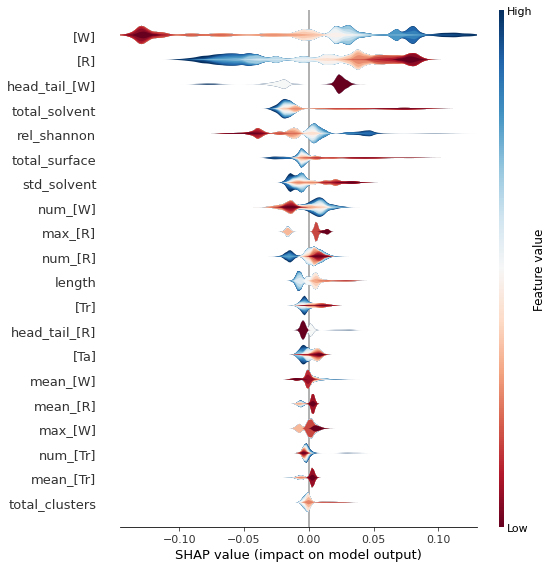

In [59]:
shap.summary_plot(shap_values_3, X_train, feature_names = feats, plot_type='layered_violin', show=False)
plt.savefig('../models/GBDT/SHAP_summary_target_4.pdf', bbox_inches='tight')

## Target 5: Second Virial ([sweep yhjo2jkc](https://app.wandb.ai/kjappelbaum/dispersant_screener/sweeps/yhjo2jkc))

We're also not predictive for second virial ...